In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from ipywidgets import interact, IntSlider

In [2]:
class Arm:
    def __init__(self, unique_id, initial_mean, initial_std, variation_func):
        self.unique_id = unique_id
        self.initial_mean = initial_mean
        self.initial_std = initial_std
        self.variation_func = variation_func
    
    def get_mean(self, t):
        return self.variation_func(self.initial_mean, t)
    
    def get_std(self, t):
        return self.initial_std
    
    def pull(self, t):
        return np.random.normal(self.get_mean(t), self.get_std(t))

In [3]:
class MultiArmedBandit:
    def __init__(self, arms, strategy='epsilon_greedy', epsilon=0.1):
        self.arms = arms
        self.n_arms = len(arms)
        self.strategy = strategy
        self.epsilon = epsilon
        self.t = 0
    
    def select_arm_random(self):
        return np.random.choice(self.arms)
    
    def select_arm_greedy(self, values):
        return max(self.arms, key=lambda arm: values[arm.unique_id])
    
    def select_arm_epsilon_greedy(self, values):
        if np.random.random() < self.epsilon:
            return self.select_arm_random()
        else:
            return self.select_arm_greedy(values)
    
    def select_arm(self, values):
        if self.strategy == 'random':
            return self.select_arm_random()
        elif self.strategy == 'greedy':
            return self.select_arm_greedy(values)
        elif self.strategy == 'epsilon_greedy':
            return self.select_arm_epsilon_greedy(values)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

In [4]:
def run_simulation(mab, n_steps):
    values = {arm.unique_id: 0 for arm in mab.arms}
    counts = {arm.unique_id: 0 for arm in mab.arms}
    cumulative_reward = 0
    rewards = []
    selections = []

    for _ in range(n_steps):
        chosen_arm = mab.select_arm(values)
        reward = chosen_arm.pull(mab.t)

        # Update tracking
        arm_id = chosen_arm.unique_id
        counts[arm_id] += 1
        n = counts[arm_id]
        value = values[arm_id]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        values[arm_id] = new_value
        cumulative_reward += reward
        rewards.append(reward)
        selections.append(arm_id)

        mab.t += 1

    return rewards, values, counts, cumulative_reward, selections

In [5]:
def visualize_true_distributions(arms, max_time=1000):
    plt.figure(figsize=(12, 6))
    x = np.linspace(-5, 5, 1000)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(arms)))
    
    def update(time):
        plt.clf()
        for i, (arm, color) in enumerate(zip(arms, colors)):
            mean = arm.get_mean(time)
            std = arm.get_std(time)
            y = norm.pdf(x, mean, std)
            plt.plot(x, y, label=f'Arm {i} (μ={mean:.2f}, σ={std:.2f})', color=color)
            
            # Add vertical line at the mean
            plt.axvline(x=mean, color=color, linestyle='--', alpha=0.7)
        
        plt.title(f"Reward Distributions for Each Arm (Time: {time})")
        plt.xlabel("Reward")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 0.5)
        plt.show()
    
    # Create an interactive slider
    time_slider = IntSlider(min=0, max=max_time, step=1, value=0, description='Time:')
    interact(update, time=time_slider)

In [6]:
# Create arms with different initial means, standard deviations, and variation functions
arms = [
    Arm(0, 0.0, 1, lambda m, t: m + 0.01 * t),
    Arm(1, 0.5, 1, lambda m, t: m + np.sin(t / 10) * 0.5),
    Arm(2, 1.0, 1, lambda m, t: m),
    Arm(3, 1.5, 1, lambda m, t: m + 0.005 * t * np.sin(t / 5)),
    Arm(4, 2.0, 1, lambda m, t: m - 0.02 * t)
]

In [7]:
# Visualize the true reward distributions
visualize_true_distributions(arms)

<Figure size 864x432 with 0 Axes>

interactive(children=(IntSlider(value=0, description='Time:', max=1000), Output()), _dom_classes=('widget-inte…

In [8]:
def visualize_arm_selection_frequencies(all_selections, arms, max_time=1000):
    plt.figure(figsize=(12, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(arms)))
    
    def update(time):
        plt.clf()
        selections_up_to_time = {strategy: selections[:time+1] for strategy, selections in all_selections.items()}
        
        x = np.arange(len(arms))
        bar_width = 0.25
        multiplier = 0

        for strategy, selections in selections_up_to_time.items():
            arm_pulls = [selections.count(arm.unique_id) for arm in arms]
            offset = bar_width * multiplier
            rects = plt.bar(x + offset, arm_pulls, bar_width, label=strategy)
            plt.bar_label(rects, padding=3)
            multiplier += 1

        plt.title(f"Arm Selection Frequencies (Time: {time})")
        plt.xlabel("Arm")
        plt.ylabel("Number of Pulls")
        plt.xticks(x + bar_width, [f"Arm {i}" for i in range(len(arms))])
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Create an interactive slider
    time_slider = IntSlider(min=0, max=max_time, step=1, value=0, description='Time:')
    interact(update, time=time_slider)

In [9]:
# Simulation parameters
num_steps = 1000
strategies = ['random', 'greedy', 'epsilon_greedy']

In [10]:
# Run simulations for each strategy
results = {}
final_values = {}
final_counts = {}
cumulative_rewards = {}
all_selections = {}

for strategy in strategies:
    mab = MultiArmedBandit(arms, strategy=strategy)
    rewards, values, counts, cumulative_reward, selections = run_simulation(mab, num_steps)
    results[strategy] = rewards
    final_values[strategy] = values
    final_counts[strategy] = counts
    cumulative_rewards[strategy] = cumulative_reward
    all_selections[strategy] = selections

In [11]:
# Visualize arm selection frequencies
visualize_arm_selection_frequencies(all_selections, arms, max_time=num_steps-1)

<Figure size 864x432 with 0 Axes>

interactive(children=(IntSlider(value=0, description='Time:', max=999), Output()), _dom_classes=('widget-inter…

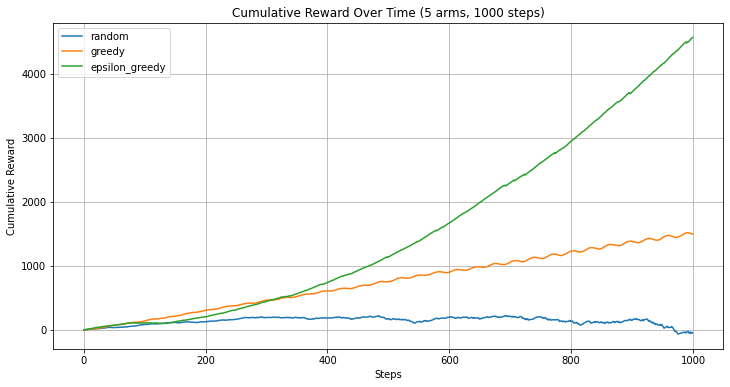

In [12]:
# Plot cumulative reward over time
plt.figure(figsize=(12, 6))
for strategy, rewards in results.items():
    plt.plot(np.cumsum(rewards), label=strategy)

plt.title(f"Cumulative Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

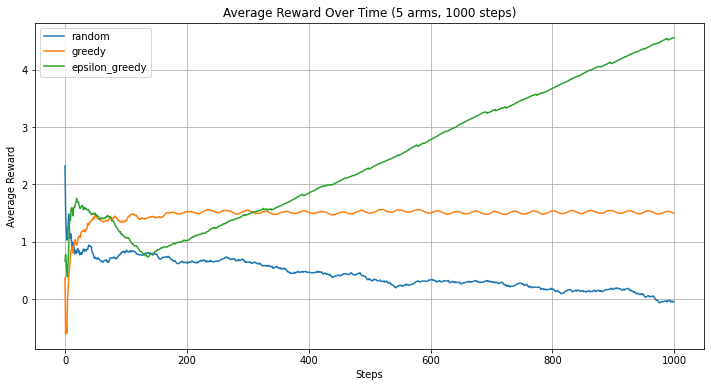

In [13]:
# Plot average reward over time
plt.figure(figsize=(12, 6))
for strategy, rewards in results.items():
    average_reward = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
    plt.plot(average_reward, label=strategy)

plt.title(f"Average Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Print final arm values and counts for each strategy
for strategy in strategies:
    print(f"\nFinal arm values and counts for {strategy} strategy:")
    for arm in arms:
        print(f"Arm {arm.unique_id}: Final mean = {arm.get_mean(num_steps-1):.2f}, "
              f"Estimated value = {final_values[strategy][arm.unique_id]:.2f}, "
              f"Pull count = {final_counts[strategy][arm.unique_id]}")
    print(f"Total reward: {cumulative_rewards[strategy]:.2f}")


Final arm values and counts for random strategy:
Arm 0: Final mean = 9.99, Estimated value = 4.81, Pull count = 194
Arm 1: Final mean = 0.21, Estimated value = 0.60, Pull count = 205
Arm 2: Final mean = 1.00, Estimated value = 1.01, Pull count = 197
Arm 3: Final mean = -3.26, Estimated value = 1.57, Pull count = 206
Arm 4: Final mean = -17.98, Estimated value = -8.19, Pull count = 198
Total reward: -43.87

Final arm values and counts for greedy strategy:
Arm 0: Final mean = 9.99, Estimated value = -0.61, Pull count = 2
Arm 1: Final mean = 0.21, Estimated value = -0.02, Pull count = 1
Arm 2: Final mean = 1.00, Estimated value = -1.13, Pull count = 1
Arm 3: Final mean = -3.26, Estimated value = 1.50, Pull count = 996
Arm 4: Final mean = -17.98, Estimated value = 0.00, Pull count = 0
Total reward: 1496.17

Final arm values and counts for epsilon_greedy strategy:
Arm 0: Final mean = 9.99, Estimated value = 5.67, Pull count = 807
Arm 1: Final mean = 0.21, Estimated value = 0.31, Pull count